<hr/>

<hr/>

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install toad

     |████████████████████████████████| 14.8 MB 2.1 MB/s            
     |████████████████████████████████| 292 kB 62.9 MB/s            
     |████████████████████████████████| 2.0 MB 48.5 MB/s            
     |████████████████████████████████| 14.8 MB 42.0 MB/s            
     |████████████████████████████████| 14.8 MB 40.0 MB/s            
     |████████████████████████████████| 14.8 MB 51.5 MB/s            
     |████████████████████████████████| 14.8 MB 44.4 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.12
    Uninstalling Cython-0.29.12:
      Successfully uninstalled Cython-0.29.12
ERROR: pip's dependency resolver does not curren

## <span id="1"></span> ** 1. Overview **

## <span id="2"></span> ** 2. Importing Libraries and Reading the Dataset **

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
from sklearn import datasets
from matplotlib import pyplot as plt
import toad
import jieba
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')

In [114]:
import time
from sklearn.datasets import load_boston
dataset = pd.read_excel("/input/fxmonth/EUR_USD_Month.xlsx")
dataset.columns

Index(['Underlying', 'Type', 'Strike', 'Expiry', 'Notional', 'Curr', 'Premium',
       'Curr.1', 'Style', 'Code', 'Clr', 'Trd Time'],
      dtype='object')

In [115]:
d_min = pd.read_excel("/input/minute/EUR_USD_Minute.xlsx")
d_min.head()

Date      ER
0  2022-11-24T00:00:00.000Z  1.0416
1  2022-11-23T23:59:00.000Z  1.0416
2  2022-11-23T23:58:00.000Z  1.0416
3  2022-11-23T23:57:00.000Z  1.0415
4  2022-11-23T23:56:00.000Z  1.0412

**Converts the string time to a unix timestamp**

In [116]:
def Changetime(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%m/%d/%Y %H:%M:%S'))*1000)
    except:
        print("**"+str1)
    return Unixtime


In [117]:
def Changetime1(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%Y-%m-%dT%H:%M:%S.000Z'))*1000)
    except:
        print("**"+str1)
    return Unixtime

Changetime1('2022-11-24T00:00:00.000Z')

1669248000000

per ms
1 1ms
1s 1000
1hour 3600000
1day 86400000
1week 604800000
1month 2629743000

In [118]:
dataset["Trd Time"] = dataset["Trd Time"].apply(Changetime)


In [119]:
d_min["ER"]

0        1.0416
1        1.0416
2        1.0416
3        1.0415
4        1.0412
5        1.0412
6        1.0413
7        1.0414
8        1.0413
9        1.0413
10       1.0413
11       1.0413
12       1.0414
13       1.0412
14       1.0413
15       1.0412
16       1.0414
17       1.0413
18       1.0411
19       1.0412
20       1.0412
21       1.0412
22       1.0412
23       1.0411
24       1.0412
25       1.0413
26       1.0411
27       1.0412
28       1.0412
29       1.0414
          ...  
38646    0.9845
38647    0.9843
38648    0.9845
38649    0.9843
38650    0.9843
38651    0.9841
38652    0.9840
38653    0.9841
38654    0.9843
38655    0.9844
38656    0.9844
38657    0.9844
38658    0.9844
38659    0.9845
38660    0.9846
38661    0.9848
38662    0.9846
38663    0.9846
38664    0.9844
38665    0.9845
38666    0.9845
38667    0.9844
38668    0.9845
38669    0.9846
38670    0.9846
38671    0.9847
38672    0.9846
38673    0.9849
38674    0.9849
38675    0.9847
Name: ER, Length: 38676,

In [120]:
d_min["Date"] = d_min["Date"].apply(Changetime1)

In [121]:
dataset.head()

Underlying Type  Strike    Expiry  Notional Curr  \
0  EUR USD Vanilla Option    C  1.0955  05/18/23  50205386  EUR   
1  EUR USD Vanilla Option    C  1.0490  05/18/23   9532889  EUR   
2  EUR USD Vanilla Option    C  1.0490  05/18/23  15252622  EUR   
3  EUR USD Vanilla Option    C  1.0420  12/02/22  10556622  EUR   
4  EUR USD Vanilla Option    C  1.0500  11/30/22  30476191  EUR   

         Premium Curr.1 Style Code Clr       Trd Time  
0  495778.187500    USD    EU   TR   U  1668788085000  
1  264061.000000    USD    EU   TR   U  1668787056000  
2  422497.625000    USD    EU   TR   U  1668787030000  
3   49616.121094    EUR    EU   TR   U  1668785461000  
4   50285.714844    USD    EU   TR   U  1668784779000

## <span id="2"></span> ** 2. data encoding **

In [122]:
dataset["Trd Time"].isnull().sum()
print(len(dataset["Trd Time"]))
print(dataset["Trd Time"][len(dataset["Trd Time"])-1])

5500
1666131967000


**find er after 1min / 30 min / 1 hour /1 day**

In [123]:
def find1min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10000 and (a-i)<10*60000):
            return j
    return -1
dataset["1min"] = dataset["Trd Time"].apply(find1min_er)
dataset["1min"].value_counts()

0.9781    48
0.9943    44
1.0032    41
0.9945    40
1.0335    39
0.9971    39
0.9947    39
0.9998    36
0.9744    35
0.9776    35
0.9912    34
0.9946    32
1.0067    27
0.9942    27
0.9944    27
0.9881    26
1.0321    26
1.0404    26
1.0028    25
0.9952    25
1.0375    25
1.0419    24
0.9788    24
1.0027    24
0.9999    23
1.0378    23
1.0308    23
0.9777    23
1.0025    23
0.9830    23
          ..
1.0356     1
1.0239     1
1.0144     1
1.0094     1
1.0214     1
1.0305     1
1.0266     1
0.9889     1
1.0418     1
1.0198     1
1.0140     1
0.9706     1
1.0458     1
1.0235     1
1.0196     1
1.0087     1
1.0193     1
1.0143     1
1.0089     1
1.0201     1
1.0165     1
1.0256     1
1.0192     1
1.0106     1
0.9737     1
0.9730     1
1.0238     1
1.0157     1
1.0279     1
1.0385     1
Name: 1min, Length: 627, dtype: int64

In [124]:
def find30min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10*60000 and (a-i)<50*60000):
            return j
    return -1
dataset["30min"] = dataset["Trd Time"].apply(find1min_er)
dataset["30min"].value_counts()

0.9781    48
0.9943    44
1.0032    41
0.9945    40
1.0335    39
0.9971    39
0.9947    39
0.9998    36
0.9744    35
0.9776    35
0.9912    34
0.9946    32
1.0067    27
0.9942    27
0.9944    27
0.9881    26
1.0321    26
1.0404    26
1.0028    25
0.9952    25
1.0375    25
1.0419    24
0.9788    24
1.0027    24
0.9999    23
1.0378    23
1.0308    23
0.9777    23
1.0025    23
0.9830    23
          ..
1.0356     1
1.0239     1
1.0144     1
1.0094     1
1.0214     1
1.0305     1
1.0266     1
0.9889     1
1.0418     1
1.0198     1
1.0140     1
0.9706     1
1.0458     1
1.0235     1
1.0196     1
1.0087     1
1.0193     1
1.0143     1
1.0089     1
1.0201     1
1.0165     1
1.0256     1
1.0192     1
1.0106     1
0.9737     1
0.9730     1
1.0238     1
1.0157     1
1.0279     1
1.0385     1
Name: 30min, Length: 627, dtype: int64

In [125]:
def find1h_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>60*60000 and (a-i)<120*60000):
            return j
    return -1
dataset["1h"] = dataset["Trd Time"].apply(find1min_er)
dataset["1h"].value_counts()

0.9781    48
0.9943    44
1.0032    41
0.9945    40
1.0335    39
0.9971    39
0.9947    39
0.9998    36
0.9744    35
0.9776    35
0.9912    34
0.9946    32
1.0067    27
0.9942    27
0.9944    27
0.9881    26
1.0321    26
1.0404    26
1.0028    25
0.9952    25
1.0375    25
1.0419    24
0.9788    24
1.0027    24
0.9999    23
1.0378    23
1.0308    23
0.9777    23
1.0025    23
0.9830    23
          ..
1.0356     1
1.0239     1
1.0144     1
1.0094     1
1.0214     1
1.0305     1
1.0266     1
0.9889     1
1.0418     1
1.0198     1
1.0140     1
0.9706     1
1.0458     1
1.0235     1
1.0196     1
1.0087     1
1.0193     1
1.0143     1
1.0089     1
1.0201     1
1.0165     1
1.0256     1
1.0192     1
1.0106     1
0.9737     1
0.9730     1
1.0238     1
1.0157     1
1.0279     1
1.0385     1
Name: 1h, Length: 627, dtype: int64

In [126]:
def find1d_er(a):
    for i,j in zip(d_min['Date'], d_min['EUR=']):
        if((a-i)>24*60*60000 and (a-i)<48*60*60000):
            return j
    return -1
dataset["1d"] = dataset["Trd Time"].apply(find1min_er)
dataset["1d"].value_counts()

0.9781    48
0.9943    44
1.0032    41
0.9945    40
1.0335    39
0.9971    39
0.9947    39
0.9998    36
0.9744    35
0.9776    35
0.9912    34
0.9946    32
1.0067    27
0.9942    27
0.9944    27
0.9881    26
1.0321    26
1.0404    26
1.0028    25
0.9952    25
1.0375    25
1.0419    24
0.9788    24
1.0027    24
0.9999    23
1.0378    23
1.0308    23
0.9777    23
1.0025    23
0.9830    23
          ..
1.0356     1
1.0239     1
1.0144     1
1.0094     1
1.0214     1
1.0305     1
1.0266     1
0.9889     1
1.0418     1
1.0198     1
1.0140     1
0.9706     1
1.0458     1
1.0235     1
1.0196     1
1.0087     1
1.0193     1
1.0143     1
1.0089     1
1.0201     1
1.0165     1
1.0256     1
1.0192     1
1.0106     1
0.9737     1
0.9730     1
1.0238     1
1.0157     1
1.0279     1
1.0385     1
Name: 1d, Length: 627, dtype: int64

In [127]:
dataset.head()

Underlying Type  Strike    Expiry  Notional Curr  \
0  EUR USD Vanilla Option    C  1.0955  05/18/23  50205386  EUR   
1  EUR USD Vanilla Option    C  1.0490  05/18/23   9532889  EUR   
2  EUR USD Vanilla Option    C  1.0490  05/18/23  15252622  EUR   
3  EUR USD Vanilla Option    C  1.0420  12/02/22  10556622  EUR   
4  EUR USD Vanilla Option    C  1.0500  11/30/22  30476191  EUR   

         Premium Curr.1 Style Code Clr       Trd Time    1min   30min      1h  \
0  495778.187500    USD    EU   TR   U  1668788085000  1.0367  1.0367  1.0367   
1  264061.000000    USD    EU   TR   U  1668787056000  1.0360  1.0360  1.0360   
2  422497.625000    USD    EU   TR   U  1668787030000  1.0356  1.0356  1.0356   
3   49616.121094    EUR    EU   TR   U  1668785461000  1.0352  1.0352  1.0352   
4   50285.714844    USD    EU   TR   U  1668784779000  1.0347  1.0347  1.0347   

       1d  
0  1.0367  
1  1.0360  
2  1.0356  
3  1.0352  
4  1.0347

In [128]:
def hotEncoding(NAME):
    value = dataset[NAME].value_counts()
    value_map = dict((v, i) for i,v in enumerate(value.index))
    dataset[NAME] = dataset.replace({NAME:value_map})[NAME]
hotEncoding('Underlying') 

In [129]:
def typecoding(NAME): 
    value1 = dataset[NAME].astype('category')
    dataset[NAME] = value1.cat.codes
typecoding('Curr')
typecoding('Type')
typecoding('Curr.1')
typecoding('Style')
typecoding('Code')
typecoding('Clr')
dataset['Underlying'] = dataset['Underlying'] +1
dataset['Type'] = dataset['Type'] +1
dataset['Curr'] = dataset['Curr'] +1
dataset['Curr.1'] = dataset['Curr.1'] +1
dataset.head()

Underlying  Type  Strike    Expiry  Notional  Curr        Premium  Curr.1  \
0           1     1  1.0955  05/18/23  50205386     1  495778.187500       2   
1           1     1  1.0490  05/18/23   9532889     1  264061.000000       2   
2           1     1  1.0490  05/18/23  15252622     1  422497.625000       2   
3           1     1  1.0420  12/02/22  10556622     1   49616.121094       1   
4           1     1  1.0500  11/30/22  30476191     1   50285.714844       2   

   Style  Code  Clr       Trd Time    1min   30min      1h      1d  
0      1     2    1  1668788085000  1.0367  1.0367  1.0367  1.0367  
1      1     2    1  1668787056000  1.0360  1.0360  1.0360  1.0360  
2      1     2    1  1668787030000  1.0356  1.0356  1.0356  1.0356  
3      1     2    1  1668785461000  1.0352  1.0352  1.0352  1.0352  
4      1     2    1  1668784779000  1.0347  1.0347  1.0347  1.0347

In [130]:
dataset = dataset.drop(['Expiry','Clr'], axis=1)
# dataset['toprice'] = dataset['Notional']/2+dataset['Premium']
# dataset['delrate'] = dataset['Premium']/(dataset['Curr']+1)
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
dataset.head()

Underlying  Type  Strike  Notional  Curr        Premium  Curr.1  Style  \
0           1     1  1.0955  50205386     1  495778.187500       2      1   
1           1     1  1.0490   9532889     1  264061.000000       2      1   
2           1     1  1.0490  15252622     1  422497.625000       2      1   
3           1     1  1.0420  10556622     1   49616.121094       1      1   
4           1     1  1.0500  30476191     1   50285.714844       2      1   

   Code       Trd Time    1min   30min      1h      1d  
0     2  1668788085000  1.0367  1.0367  1.0367  1.0367  
1     2  1668787056000  1.0360  1.0360  1.0360  1.0360  
2     2  1668787030000  1.0356  1.0356  1.0356  1.0356  
3     2  1668785461000  1.0352  1.0352  1.0352  1.0352  
4     2  1668784779000  1.0347  1.0347  1.0347  1.0347

## <span id="3"></span> ** 3. Data Analysis **

### <span id="4"></span> ** Data Preprocessing **

Are there missing values? There isn't any missing values as shown below.

In [131]:
dataset= dataset.dropna()


### <span id="5"></span> ** using toad to perform exploratory data analysis and visualization**

In [132]:
dataset.isnull().sum()

Underlying    0
Type          0
Strike        0
Notional      0
Curr          0
Premium       0
Curr.1        0
Style         0
Code          0
Trd Time      0
1min          0
30min         0
1h            0
1d            0
dtype: int64

In [133]:
tance = toad.detector.detect(dataset)

In [134]:
tance

type  size missing  unique  mean_or_top1   std_or_top2  \
Underlying    int64  5500   0.00%       1  1.000000e+00  0.000000e+00   
Type           int8  5500   0.00%       1  1.000000e+00  0.000000e+00   
Strike      float64  5500   0.00%     605  1.031947e+00  5.382283e-02   
Notional      int64  5500   0.00%    2746  4.288902e+07  5.414910e+07   
Curr           int8  5500   0.00%       1  1.000000e+00  0.000000e+00   
Premium     float64  5500   0.00%    4655  4.071870e+05  8.251832e+05   
Curr.1         int8  5500   0.00%       2  1.752000e+00  4.318911e-01   
Style          int8  5500   0.00%       2  9.989091e-01  3.301389e-02   
Code           int8  5500   0.00%       3  1.969273e+00  2.342733e-01   
Trd Time      int64  5500   0.00%    4339  1.667604e+12  7.885181e+08   
1min        float64  5500   0.00%     627  1.002699e+00  7.466451e-02   
30min       float64  5500   0.00%     627  1.002699e+00  7.466451e-02   
1h          float64  5500   0.00%     627  1.002699e+00  7.466451e-02   
1d          float64  5500   0.00%     627  1.002699e+00  7.466451e-02   

             min_or_top3    1%_or_top4   10%_or_top5  50%_or_bottom5  \
Underlying  1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Type        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Strike      0.000000e+00  9.772970e-01  9.900000e-01    1.022000e+00   
Notional    1.010000e+02  8.236400e+04  1.960784e+06    2.490851e+07   
Curr        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Premium     0.000000e+00  0.000000e+00  6.756246e+03    1.787638e+05   
Curr.1      1.000000e+00  1.000000e+00  1.000000e+00    2.000000e+00   
Style       0.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Code        0.000000e+00  0.000000e+00  2.000000e+00    2.000000e+00   
Trd Time    1.666132e+12  1.666161e+12  1.666360e+12    1.667810e+12   
1min       -1.000000e+00  9.742000e-01  9.782000e-01    9.999000e-01   
30min      -1.000000e+00  9.742000e-01  9.782000e-01    9.999000e-01   
1h         -1.000000e+00  9.742000e-01  9.782000e-01    9.999000e-01   
1d         -1.000000e+00  9.742000e-01  9.782000e-01    9.999000e-01   

            75%_or_bottom4  90%_or_bottom3  99%_or_bottom2  max_or_bottom1  
Underlying    1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Type          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Strike        1.050000e+00    1.080000e+00    1.218515e+00    1.600000e+00  
Notional      5.017053e+07    1.023256e+08    2.410824e+08    2.505010e+08  
Curr          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Premium       4.579881e+05    9.492521e+05    3.567985e+06    2.971315e+07  
Curr.1        2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Style         1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Code          2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Trd Time      1.668173e+12    1.668577e+12    1.668769e+12    1.668788e+12  
1min          1.028800e+00    1.037800e+00    1.042901e+00    1.047300e+00  
30min         1.028800e+00    1.037800e+00    1.042901e+00    1.047300e+00  
1h            1.028800e+00    1.037800e+00    1.042901e+00    1.047300e+00  
1d            1.028800e+00    1.037800e+00    1.042901e+00    1.047300e+00

## <span id="3"></span> 1. 1min model 

In [135]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (3850, 2)
Shape of X_test:  (1650, 2)
Shape of y_train:  (3850,)
Shape of y_test (1650,)


In [136]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.017698396386518746
R2_score (train):  0.0016105889605354529
R2_score (test):  0.0008599218680885867
RMSE:  0.08804533329375847


In [137]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.04196028891559467
R2_score (train):  0.0034435992472025
R2_score (test):  0.002684058577781756
RMSE:  0.08796492409975218


In [ ]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [138]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -4.576242121306768
R2_score (train):  0.9997685149059891
R2_score (test):  -0.2977962630923392
RMSE:  0.10034515576631897


In [139]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -1.4715825538847047
R2_score (train):  0.837509269499202
R2_score (test):  0.06948749098891105
RMSE:  0.08496777771992703


In [140]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.088045            0.001611        0.000860         -0.017698
1   SVM  0.087965            0.003444        0.002684         -0.041960
2   KNN  0.100345            0.999769        0.297796          4.576242
3    RF  0.084968            0.837509        0.069487          1.471583

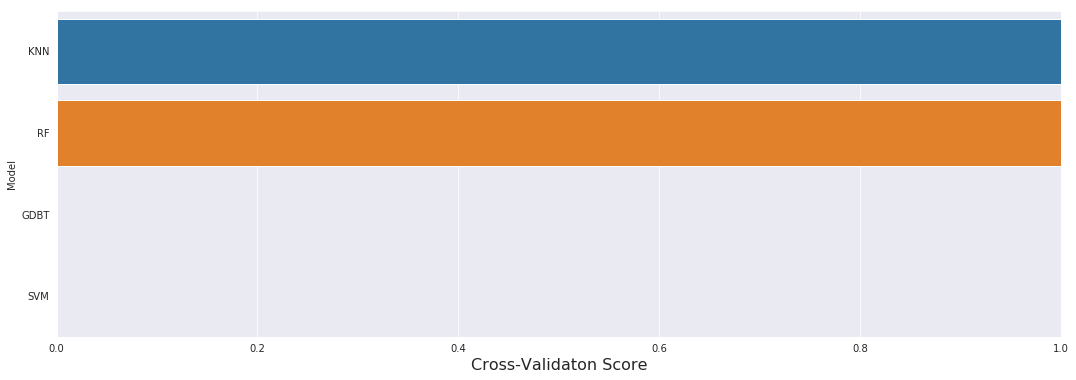

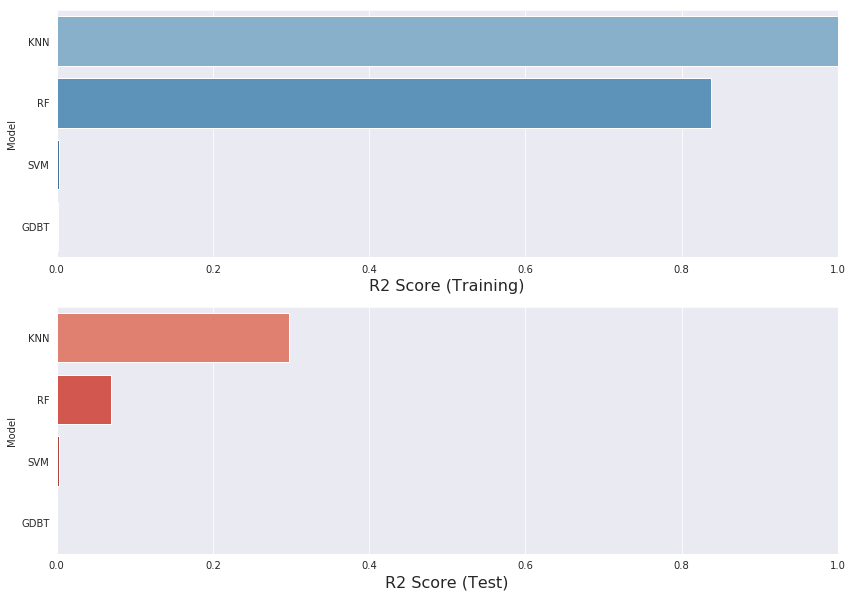

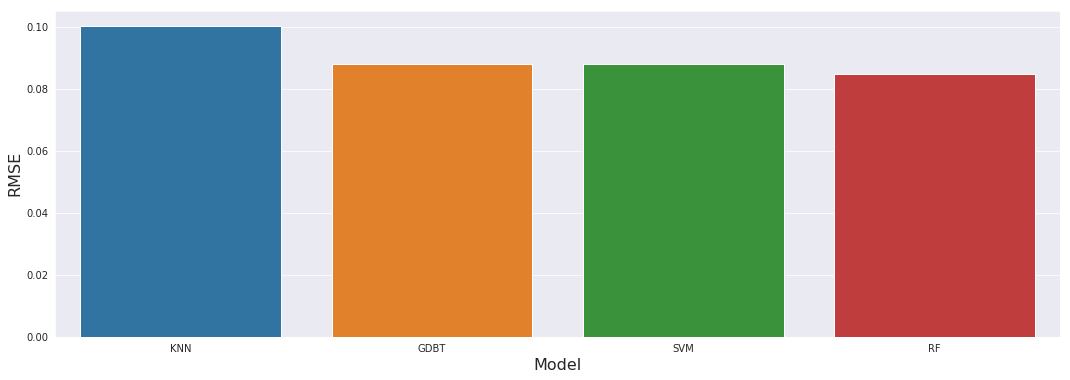

In [141]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 2. 30min model 

In [142]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,11]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (3850, 2)
Shape of X_test:  (1650, 2)
Shape of y_train:  (3850,)
Shape of y_test (1650,)


In [143]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.017698396386518746
R2_score (train):  0.0016105889605354529
R2_score (test):  0.0008599218680885867
RMSE:  0.08804533329375847


In [144]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.04196028891559467
R2_score (train):  0.0034435992472025
R2_score (test):  0.002684058577781756
RMSE:  0.08796492409975218


In [ ]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [145]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -4.576242121306768
R2_score (train):  0.9997685149059891
R2_score (test):  -0.2977962630923392
RMSE:  0.10034515576631897


In [146]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -1.4715825538847047
R2_score (train):  0.837509269499202
R2_score (test):  0.06948749098891105
RMSE:  0.08496777771992703


In [147]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.088045            0.001611        0.000860         -0.017698
1   SVM  0.087965            0.003444        0.002684         -0.041960
2   KNN  0.100345            0.999769        0.297796          4.576242
3    RF  0.084968            0.837509        0.069487          1.471583

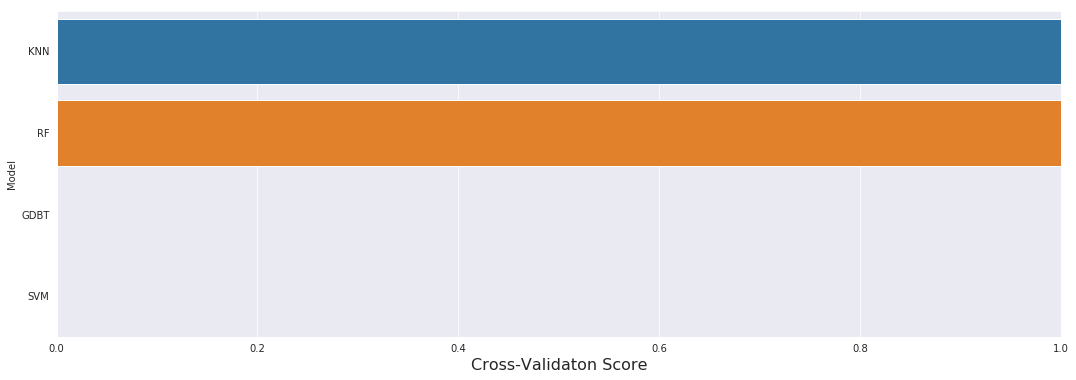

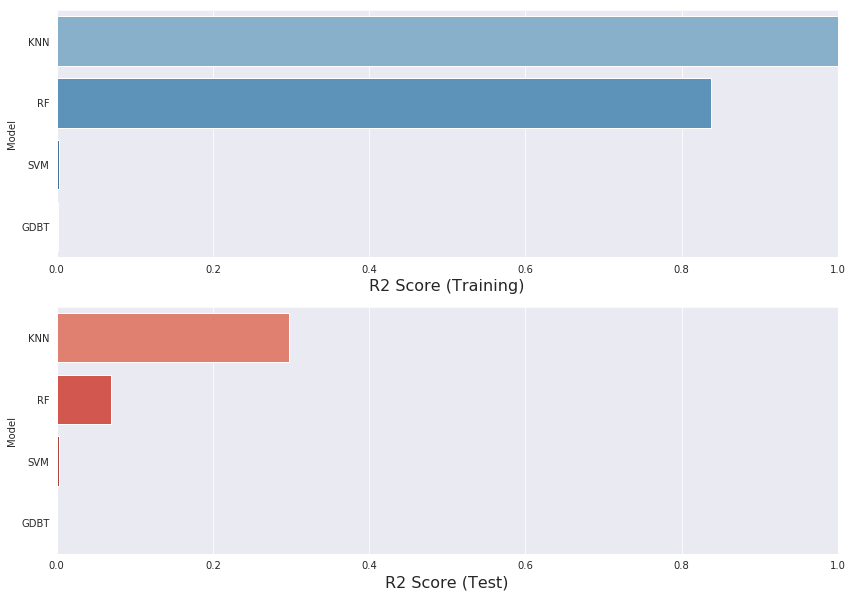

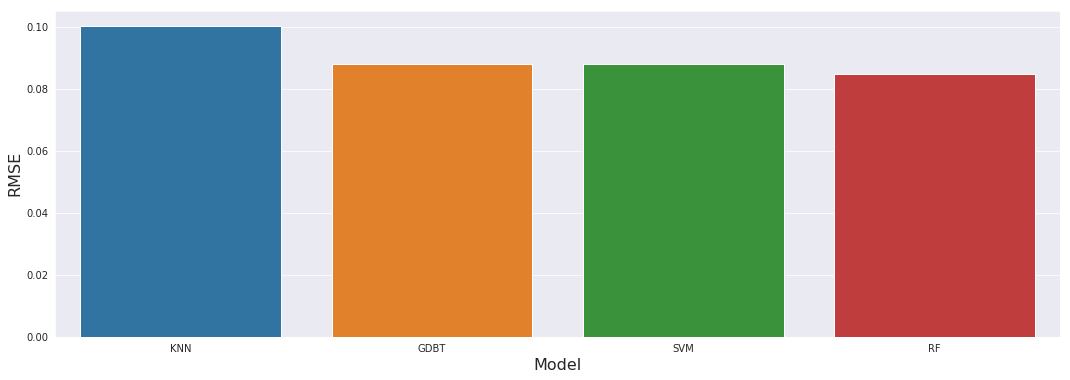

In [148]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 3. 1hour model 

In [149]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (3850, 2)
Shape of X_test:  (1650, 2)
Shape of y_train:  (3850,)
Shape of y_test (1650,)


In [150]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.017698396386518746
R2_score (train):  0.0016105889605354529
R2_score (test):  0.0008599218680885867
RMSE:  0.08804533329375847


In [151]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.04196028891559467
R2_score (train):  0.0034435992472025
R2_score (test):  0.002684058577781756
RMSE:  0.08796492409975218


In [ ]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [152]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -4.576242121306768
R2_score (train):  0.9997685149059891
R2_score (test):  -0.2977962630923392
RMSE:  0.10034515576631897


In [153]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -1.4715825538847047
R2_score (train):  0.837509269499202
R2_score (test):  0.06948749098891105
RMSE:  0.08496777771992703


In [154]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.088045            0.001611        0.000860         -0.017698
1   SVM  0.087965            0.003444        0.002684         -0.041960
2   KNN  0.100345            0.999769        0.297796          4.576242
3    RF  0.084968            0.837509        0.069487          1.471583

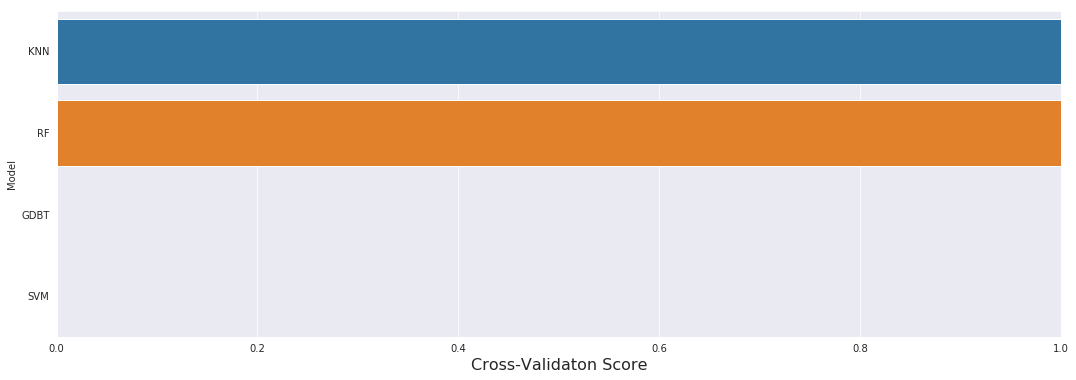

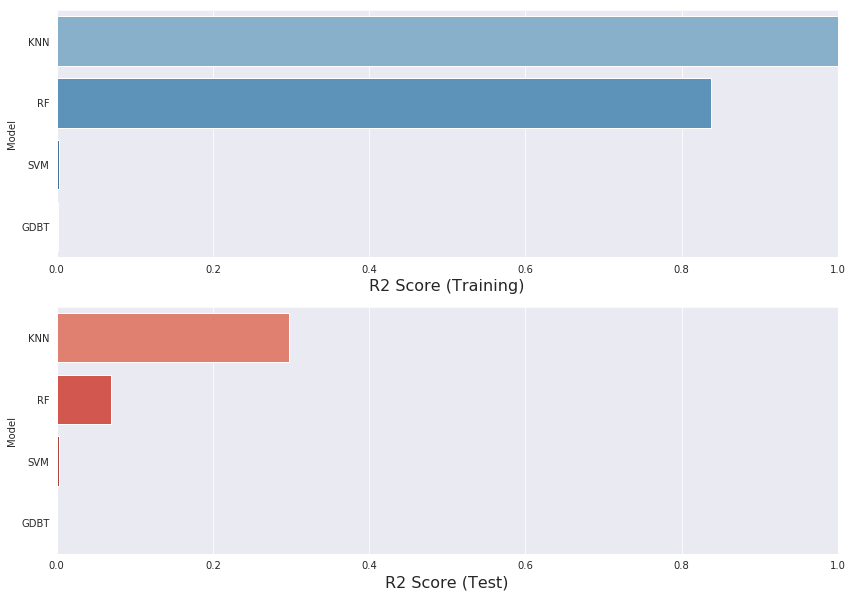

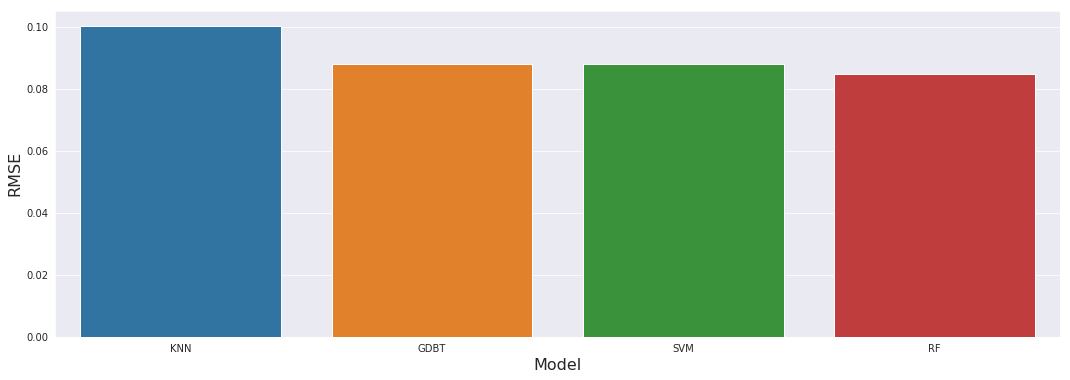

In [155]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 1. 1day model 

In [156]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (3850, 2)
Shape of X_test:  (1650, 2)
Shape of y_train:  (3850,)
Shape of y_test (1650,)


In [157]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.017698396386518746
R2_score (train):  0.0016105889605354529
R2_score (test):  0.0008599218680885867
RMSE:  0.08804533329375847


In [158]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.04196028891559467
R2_score (train):  0.0034435992472025
R2_score (test):  0.002684058577781756
RMSE:  0.08796492409975218


In [159]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [160]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -4.576242121306768
R2_score (train):  0.9997685149059891
R2_score (test):  -0.2977962630923392
RMSE:  0.10034515576631897


In [161]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -1.4715825538847047
R2_score (train):  0.837509269499202
R2_score (test):  0.06948749098891105
RMSE:  0.08496777771992703


In [162]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.088045            0.001611        0.000860         -0.017698
1   SVM  0.087965            0.003444        0.002684         -0.041960
2   KNN  0.100345            0.999769        0.297796          4.576242
3    RF  0.084968            0.837509        0.069487          1.471583

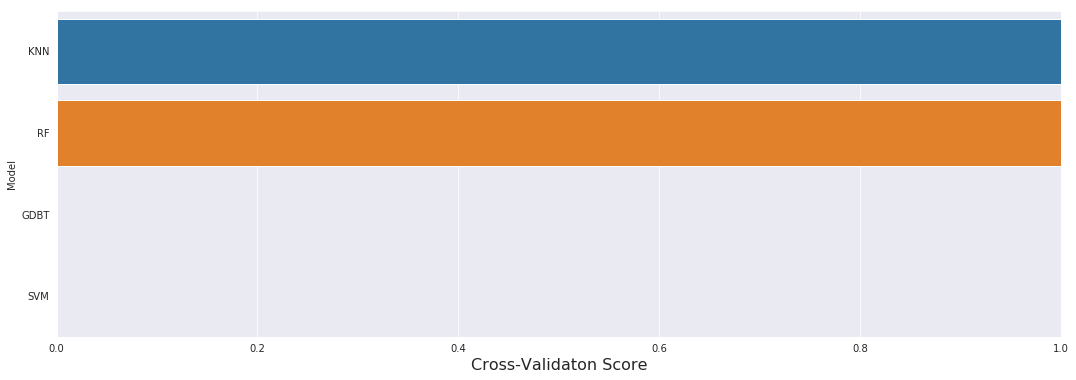

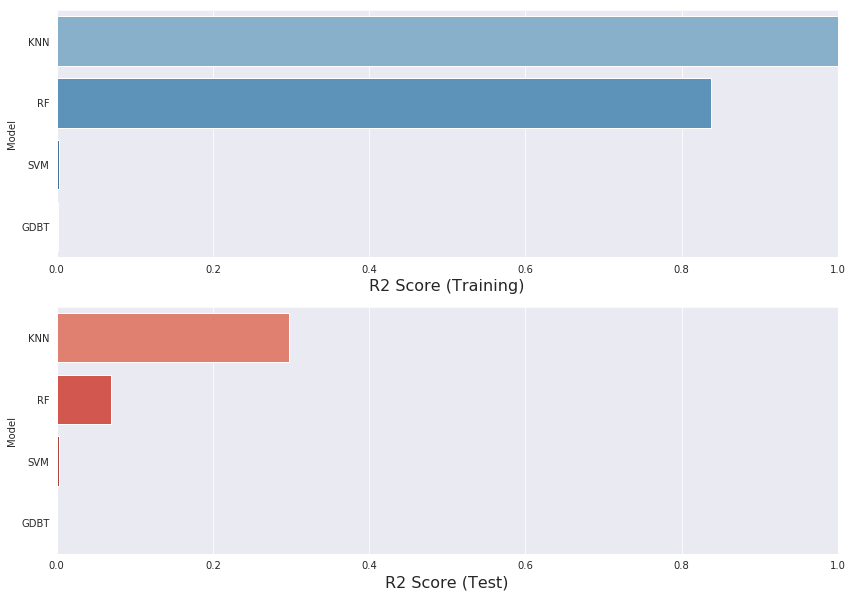

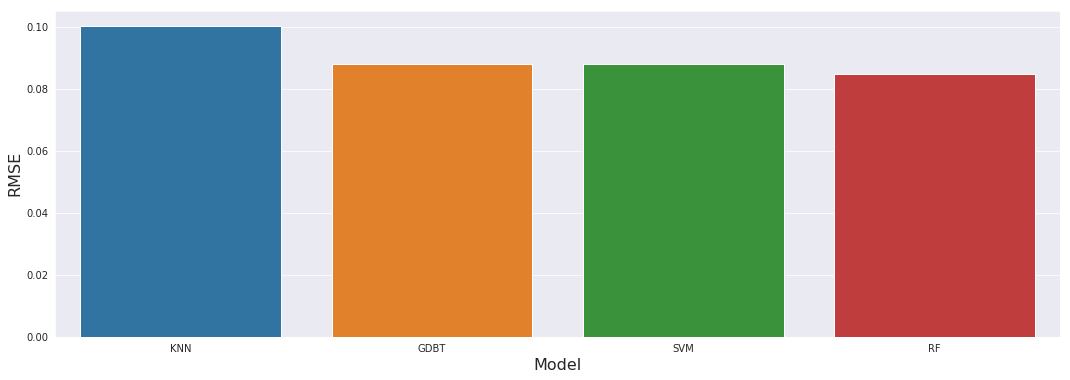

In [163]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

------------

**origin **

------------

In [ ]:
y = dataset.iloc[:,5]
X = dataset.drop('Premium', axis=1).iloc[:,:]

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [ ]:
dataset.head()

In [ ]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

### <span id="5"></span> ** Visualizing Data **

### <span id="5"></span> **Correlations can be found by thermal maps **

In [ ]:
corr = dataset.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [ ]:
sns.pairplot(dataset)
plt.show()

## <span id="6"></span> ** 4. Regression Models **

### <span id="7"></span> ** gdbt **

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

### <span id="11"></span> ** SVM **

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

In [ ]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#第五步：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression
print 'R-squared value of uniform-weighted KNR is',uni_knr.score(X_test,y_test)
print 'the MSE of uniform-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
print 'the MAE of uniform-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
#2.The prediction method is KNR according to the weighted distance
print 'R-squared value of distance-weighted KNR is',dis_knr.score(X_test,y_test)
print 'the MSE of distance-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))
print 'the MAE of distance-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

### <span id="13"></span> ** Random Forest Regression **

In [ ]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

## <span id="14"></span> ** 5. Measuring the Error **

In [ ]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]

In [ ]:
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

### <span id="15"></span> ** Visualizing Model Performance **

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

In [ ]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()

In [ ]:
predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="16"></span> ** 6. Conclusion **